In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
from tests.leandro.hierarchical_clustering_analysis import *
from tests.leandro.hierarchical_clustering import *
from tests.leandro.tools import get_real_data, get_one_worm_data

In [124]:
# Real data
dataset = get_real_data('/home/lrvnc/Projects/worm-graph/conf/dataset.yaml')
oneWorm, calcium_data, time_vector = get_one_worm_data(dataset)


config:
	 dataset:
  name: Flavell2023


Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Worm ID: worm32


# Clustering the data
---

To initiate a hierarchical cluster analysis, we can invoke the function `hierarchical_clustering_analysis`, providing the dataset specific to one worm and specifying the desired number of clusters as parameters.

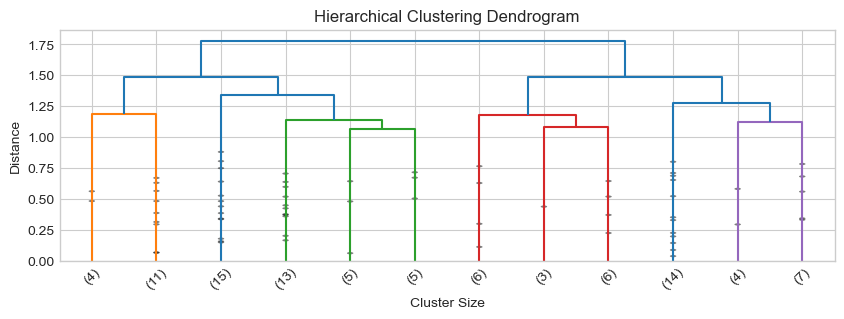

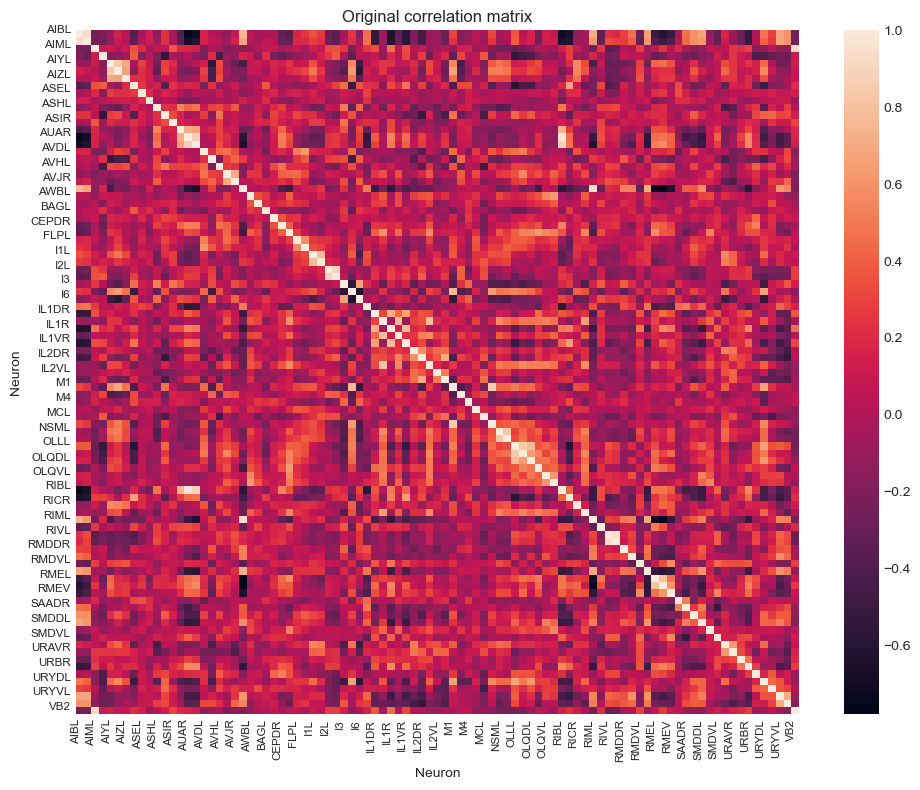

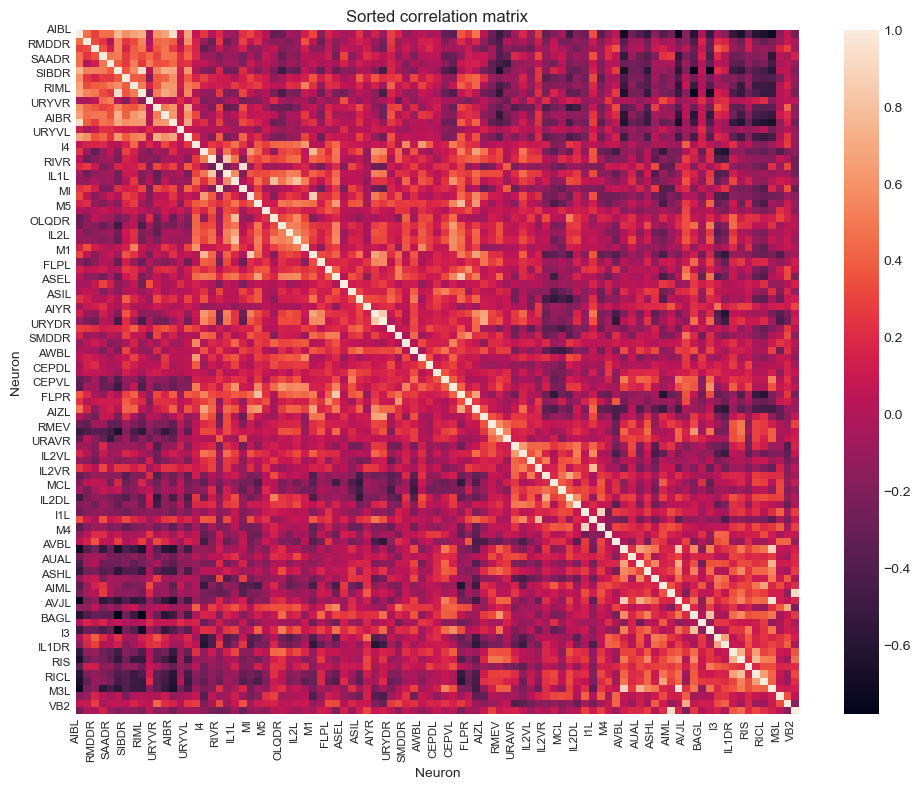

In [182]:
clusters = hierarchical_clustering_analysis(oneWorm, criterion_value=4, show_plots=True)

The function hierarchical_clustering_analysis returns two dataframes:
* The first one containing information about the neurons and their computed cluster labels. It also includes the corresponding neuron classification that can be found in the literature.
* The second one dataframe provides a count of the neuron types within each cluster.

In [183]:
clusters.head()

,Computed Cluster,Reference
AIBL,1,interneuron
RMDL,1,motor
RMDDR,1,motor
IL1DL,1,"sensory, motor, interneuron"
SAADR,1,"motor, interneuron"


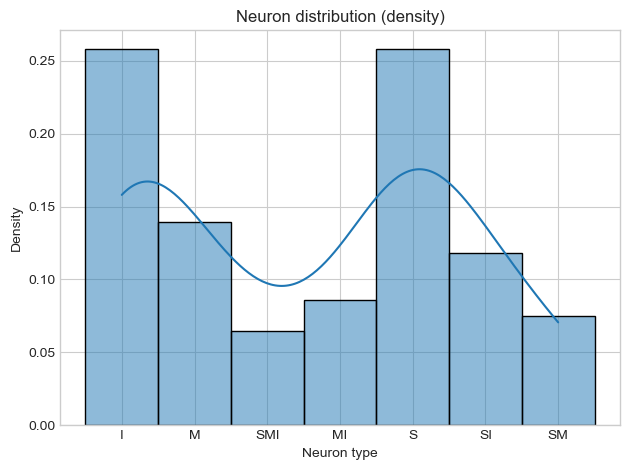

In [184]:
clusters = neuron_distribution(clusters, stat='density', group_by=None)

In [185]:
clusters

,Computed Cluster,Reference
AIBL,1,I
RMDL,1,M
RMDDR,1,M
IL1DL,1,SMI
SAADR,1,MI
...,...,...
RICL,4,I
RIBL,4,I
M3L,4,SM
AVJR,4,I


In [186]:
create_total(count_inside_clusters)

Reference,interneuron,motor,"motor, interneuron",sensory,"sensory, interneuron","sensory, motor","sensory, motor, interneuron",total
Computed Cluster,,,,,,,,
1,2.0,4.0,5.0,3.0,0.0,0.0,1.0,15.0
2,8.0,3.0,3.0,15.0,5.0,2.0,2.0,38.0
3,1.0,3.0,0.0,4.0,4.0,3.0,0.0,15.0
4,13.0,3.0,0.0,2.0,2.0,2.0,3.0,25.0
total,24.0,13.0,8.0,24.0,11.0,7.0,6.0,93.0


The computed clusters can vary based on the chosen criterion, metric, and method. Here are the options available for exploration:

* Method:
    - 'single': Uses the minimum distance between observations in different clusters.
    - 'complete': Uses the maximum distance between observations in different clusters.
    - 'average': Uses the average distance between observations in different clusters.
    - 'weighted': Uses the weighted distance between observations in different clusters.
    - 'centroid': Uses the distance between centroids of clusters.
    - 'median': Uses the distance between medians of clusters.
    - 'ward': Minimizes the variance when merging clusters. ([More details](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html))

* Metric:
    - Various distance metrics can be used to compute the pairwise distances between observations. Some common options include Euclidean distance, Manhattan distance, and correlation distance. The complete list of possibilities can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist).

* Criterion:
    - 'inconsistent': Provides statistics on the inconsistency of clusters.
    - 'distance': Forms flat clusters based on a specified distance threshold.
    - 'maxclust': Forms flat clusters by specifying the desired number of clusters.
    - 'monocrit': Forms flat clusters based on a specific monocriterion.
    - 'maxclust_monocrit': Forms flat clusters based on a monocriterion with a specified number of clusters. ([More details](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster))

# Analysis tools
---

To gain insights into the main type of each computed cluster based on the counts, you can utilize the following functions:

1. `group_by_four(df)`: This function reorganizes the counts based on the four neuron classifications found in the literature, namely: interneuron, motor, sensory, and polymodal.

2. `group_by_three(df)`: This function reorganizes the counts by considering the hypothesis that the polymodal neurons are involved in only one function during the data collection. The resulting dataframe will have three classifications: interneuron, motor, and sensory.

In [ ]:
gbt = group_by_three(count_inside_clusters)
gbt

Reference,interneuron,motor,sensory,total
Computed Cluster,,,,
1,8.0,1.0,3.0,12.0
2,5.0,5.0,2.0,12.0
3,8.0,2.0,16.0,26.0
4,3.0,5.0,13.0,21.0
total,24.0,13.0,34.0,71.0


In [ ]:
gbf = group_by_four(count_inside_clusters)
gbf

Reference,interneuron,motor,sensory,polymodal,total
Computed Cluster,,,,,
1,7.0,1.0,3.0,1.0,12.0
2,2.0,5.0,2.0,3.0,12.0
3,6.0,2.0,9.0,9.0,26.0
4,3.0,5.0,6.0,7.0,21.0
total,18.0,13.0,20.0,20.0,71.0


To view the percentages, you can utilize the `convert_to_percentages` function. By calling this function and specifying the `dimension` parameter, you can choose whether to analyze the percentages within each computed cluster or globally based on neuron reference.

In [ ]:
gbt_percentage = convert_to_percentages(gbt, dimension='reference') # dimension can be 'computed-cluster' or 'reference'
gbt_percentage

Reference,interneuron,motor,sensory,total
Computed Cluster,,,,
1,33.33,7.69,8.82,16.90
2,20.83,38.46,5.88,16.90
3,33.33,15.38,47.06,36.62
4,12.50,38.46,38.24,29.58
total,100.00,100.00,100.00,100.00


# Consistency across datasets
---

In [ ]:
all_worm_clusters_list = []
all_worm_count_inside_clusters_list = []

for wormID in dataset.keys():
    clusters, count_inside_clusters = hierarchical_clustering_analysis(dataset[wormID], criterion_value=4, show_plots=False)
    all_worm_clusters_list.append(clusters.drop(columns=['Reference']))
    all_worm_count_inside_clusters_list.append(count_inside_clusters)

In [ ]:
# Count inside Reference

TypeError: unique() got an unexpected keyword argument 'return_counts'

In [ ]:
percentages = convert_to_percentages(group_by_four(count_inside_clusters), dimension='computed-cluster')
percentages = delete_total(percentages)
# Take the name of the column with the highest value for each row
percentages['Computed cluster'] = percentages.idxmax(axis=1)
percentages

Reference,interneuron,motor,sensory,polymodal,Computed cluster
Computed Cluster,,,,,
1,38.46,15.38,15.38,30.77,interneuron
2,28.00,12.00,32.00,28.00,sensory
3,13.64,13.64,31.82,40.91,polymodal
4,35.71,14.29,28.57,21.43,interneuron


In [ ]:
file_path = '/home/lrvnc/Projects/worm-graph/tests/leandro/data/neuron_clusters.json'

try:
    with open(file_path, 'r') as f:
        neuron_classification = json.load(f)
except FileNotFoundError:
    print(f"File not found at path: {file_path}")
except json.JSONDecodeError as e:
    print(f"Error while decoding JSON: {e}")

In [ ]:
all_worm_clusters = pd.concat(all_worm_clusters_list, axis=1, keys=range(1, len(all_worm_clusters_list) + 1))
all_worm_clusters.columns = [f"worm{i}" for i in range(1, len(all_worm_clusters_list) + 1)]
all_worm_clusters['Reference'] = 0

for neuron in all_worm_clusters.index:
    all_worm_clusters.loc[neuron, 'Reference'] = ', '.join(neuron_classification[neuron])

all_worm_clusters

,worm1,worm2,worm3,worm4,worm5,worm6,worm7,worm8,worm9,worm10,...,worm42,worm43,worm44,worm45,worm46,worm47,worm48,worm49,worm50,Reference
SAAVR,1.0,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN,3.0,...,2.0,NaN,4.0,2.0,NaN,NaN,NaN,NaN,2.0,"motor, interneuron"
AWAR,1.0,4.0,NaN,1.0,2.0,NaN,NaN,1.0,1.0,1.0,...,2.0,NaN,4.0,NaN,4.0,1.0,NaN,3.0,2.0,sensory
AWBL,1.0,4.0,3.0,4.0,4.0,4.0,2.0,4.0,2.0,1.0,...,NaN,2.0,4.0,NaN,1.0,NaN,4.0,NaN,3.0,sensory
AWBR,1.0,4.0,3.0,4.0,1.0,NaN,NaN,NaN,2.0,1.0,...,NaN,NaN,4.0,2.0,NaN,NaN,3.0,NaN,NaN,sensory
SAAVL,1.0,NaN,4.0,1.0,4.0,NaN,NaN,3.0,NaN,3.0,...,NaN,3.0,2.0,NaN,NaN,1.0,4.0,NaN,2.0,"motor, interneuron"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIBDR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"motor, interneuron"
RIBR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,1.0,interneuron
RMGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,interneuron
AVBR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,interneuron
